# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков и визуальный анализ данных
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *conda install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#conda install seaborn
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие 13 признаков:**
- time_diff1, ..., time_diff9 – промежутки между посещением 1 и 2 сайта, ..., 9 и 10 сайта в сессии (в секундах). Посещения сайтов не сторого упорядочены по времени, поэтому эти величины где-то могут быть отрицательными. Если сайтов в сессии меньше 10, разницы можно сделать нулевыми
- session_timespan – продолжительность сессии. Из-за того, что посещения сайтов не сторого упорядочены по времени, продолжительностью сессии будем считать разницу между максимальным и минимальным временем посещения сайтов в сессии (в секундах).
- #unique_sites – число уникальных сайтов в сессии 
- start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 13 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *time_diff1*, ..., *time_diff9*, *session_timespan*, *#unique_sites*, *start_hour*,*day_of_week*,*target* (это видно и чуть ниже по тому, как функция вызывается).

In [2]:
glob('capstone_websites_data/3users_toy/*.csv')

['capstone_websites_data/3users_toy/user3.csv',
 'capstone_websites_data/3users_toy/user1.csv',
 'capstone_websites_data/3users_toy/user2.csv']

In [4]:
df = pd.read_csv(
    'capstone_websites_data/3users_toy/user3.csv', 
    header=None, 
    names=['id', 'timestamp', 'site'])

In [5]:
df

,id,timestamp,site
0,3,2013-11-15T09:28:17,meduza.io
1,3,2013-11-15T09:33:04,google.com
2,3,2013-11-15T09:52:48,oracle.com
3,3,2013-11-15T11:37:26,google.com
4,3,2013-11-15T11:40:32,oracle.com
5,3,2013-11-15T11:40:34,google.com
6,3,2013-11-15T11:40:35,google.com
7,3,2013-11-15T11:40:37,mail.google.com
8,3,2013-11-15T11:40:40,yandex.ru
9,3,2013-11-15T11:41:35,meduza.io


In [6]:
def correct_matrix_width(matr, width, to_np=True):
    matr = list(map(
        lambda x: list(map(
                lambda y: y 
                if len(y) >= width
                else y + [0]*(width - len(y)), 
                x)), 
        matr))
    matr = np.array(list(map(
                lambda y: np.array(list(map(np.array, y))), 
                matr)))
    matr = np.vstack(matr)
    return matr

In [11]:
def chunks(l, n, step=None):
    """Yield successive n-sized chunks from l."""
    if step is None:
        step = n
    for i in range(0, len(l), step):
        yield l[i:i + n]

In [12]:
def parse_df_column(df, column, session_length, window_size):
    tmp_s = []
    for x in chunks(df[column].values.tolist(), 
                    session_length, window_size):
        tmp_s.append(x)
    return tmp_s

In [13]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [14]:
def prepare_train_set_with_fe(
    csv_files_mask, site_freq_path, feature_names,
    session_length=10, window_size=10):
    
    sessions = []
    deltas = []
    for file in sorted(glob(csv_files_mask)):
        df = pd.read_csv(
            file, header=None, 
            names=['id', 'timestamp', 'site'])
        
        df.drop_duplicates()
        
        sessions.append(
            parse_df_column(df, "site", 
                            session_length, window_size))
        deltas.append(
            parse_df_column(df, "timestamp", 
                            session_length, window_size))
        
    import pdb; pdb.set_trace()
    deltas = list(map(
        lambda x: list(map(
                lambda y: y[0] - y[1],
                pairwise(x))),
        deltas))
    import pdb; pdb.set_trace()
        
    
    with open(site_freq_path, "rb") as f_in:
        site2id = pickle.load(f_in)
    
    sessions = list(map(
        lambda x: list(map(
                lambda y: [x[0]] + list(map(
                        lambda z: site2id[z][0], 
                        y)), 
                x[1])), 
        enumerate(sessions)))
    
    sessions = correct_matrix_width(
        sessions, session_length+1, to_np=True)
    
    df2 = pd.DataFrame(
        data=sessions, 
        columns=["target"] + 
        ["site{}".format(i+1) for i in range(session_length)])
    df2.drop_duplicates()
    
    
    
    df2 = df2[feature_names]
    
    return df2

In [18]:
def prepare_train_set_with_fe(csv_files_mask, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' input 
    csv_files_mask = dir of session files,
    site_freq_path = dir of dictionary,
    feature_names  = names of the features
    session_length = N size of the session ,
    window_size    = M size of the window
    output 
    dataFrame where  site1,...site(N) are the site in the session 
            time_diff1,... time_diff(N-1) are the difference between the open time of each site in the session
            unique_site is the number of the unique site in the session
            start_hour is the hour of the start the session
            day_of_week is the day of the start the session
            target is the user_id
    '''
    data = pd.DataFrame(columns = feature_names, dtype=np.int64)
    
    with open(site_freq_path, "rb") as dic_pkl:
        # dictionary 
        #     where keys are site names values are 
        #     (site_id, frequency of site_id)
        dic =pickle.load(dic_pkl)    
    
    # from csv_files_mask to read all files
    for f in glob(csv_files_mask):
        # make the dataframe from file
        df = pd.read_csv(
            f, 
            header=None, 
            names=['id', 'timestamp', 'site']) 
        N_rows = int(np.ceil(len(df)/float(window_size)))
        
        ar = list(map(lambda x: dic[x][0], df.site.values))
        
        ar_time = pd.to_datetime(df['timestamp']).values
        
        N_unique_site = np.zeros(N_rows, dtype = np.int64)
        ar2 = np.array([], dtype = np.int64)
        ar2_time = np.array([] ,dtype='datetime64')
        
        for i in range (N_rows+1):
            # sites in the session length with window size
            sites_setion = ar[
                i*window_size : i*window_size + session_length]
            ar2 = np.append(ar2, sites_setion)
            # запишем время посешения сайта 
            #     в матрицу по сессиям длины session_length 
            #     и с окном длины window_size
            ar2_time = np.append(
                ar2_time, 
                ar_time[i*window_size : i*window_size + session_length])
            
            if i == N_rows: 
                break 
            # колличество уникальных сайтов в сессии 
            N_unique_site[i] = len(np.unique(sites_setion))
        
        # добавим в пустые згачения 0
        ar2 = np.append(
            ar2,np.tile(
                [0], 
                (N_rows*session_length - len(ar2)))) 
        
        # добавим в пустые значения последнее время
        ar2_time = np.append(
            ar2_time, 
            np.tile(
                ar_time[-1], 
                (N_rows*session_length - len(ar2_time)))) 
        
        # convert array to matrixs
        ar2 = ar2.reshape(
            (N_rows, session_length))
        
        # convert array to matrix
        ar2_time = ar2_time.reshape(
            (N_rows, session_length))
        
        # convert array to matrix
        N_unique_site = N_unique_site.reshape((N_rows, 1))
        
        # время между посещениями сайтов в одной сессии в секундах
        time_diff = np.diff(ar2_time, axis=1)/np.timedelta64(1, 's')
        
        # продолжительность сессии в сек
        session_timespan = (
            np.max(ar2_time, axis =1) - 
            np.min(ar2_time, axis =1))/np.timedelta64(1, 's') 
        
        # convert array to matrix
        session_timespan = session_timespan.reshape(
            (N_rows, 1)).astype(int)
        
        # час начала сессии
        start_hour = (pd.to_datetime(np.min(ar2_time, axis =1))).hour
        # convert array to matrix
        start_hour = start_hour.reshape((N_rows, 1))
        
        # день недели начала сессии    
        day_of_week = (pd.to_datetime(np.min(ar2_time, axis =1))).dayofweek
        # convert array to matrix
        day_of_week = day_of_week.reshape((N_rows, 1))
        
        matrix = (np.hstack(
                (ar2, time_diff, 
                 session_timespan, 
                 N_unique_site, 
                 start_hour, 
                 day_of_week))).astype(np.int64)
        
        data_ = pd.DataFrame(
            matrix, 
            columns = feature_names[:-1], 
            dtype = np.int64)
        
        # target
        data_[feature_names[-1]] = df['id']
        data_ = data_.astype(np.int64)
        data = data.append(data_)
        
    return data.astype(np.int64)

**Проверим функцию на игрушечном примере.**

In [19]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(
    'capstone_websites_data/3users_toy/*.csv', 
    site_freq_path='capstone_websites_data/site_freq_3users.pkl',
    feature_names=feature_names, session_length=10)

In [20]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,7,5,8,5,8,5,5,6,11,7,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
1,7,5,8,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3
0,10,8,8,4,8,5,1,6,2,9,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,10,5,5,5,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
0,10,8,3,3,8,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2


In [4]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,9,2,1,10,5,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите session_length=10.**

In [21]:
train_data_10users = prepare_train_set_with_fe(
    'capstone_websites_data/10users/*', 
    site_freq_path='capstone_websites_data/site_freq_10users.pkl',
    feature_names=feature_names, session_length=10)

In [22]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,140,144,2426,142,143,140,144,142,143,2426,3,2,41,1,1,0,0,0,0,48,5,13,4,128
1,2426,691,272,2889,691,2889,272,2889,4172,140,0,0,0,1,0,0,1,0,1,3,6,13,4,128
2,2426,4172,272,2426,655,364,2889,2889,655,2889,0,0,1,0,0,1,1,8,2,13,6,13,4,128
3,2889,272,2426,2426,364,2426,2426,2400,2400,3747,0,8,18,47,11,18,137,17,26,282,6,13,4,128
4,3747,4172,655,2400,2400,3747,2400,2400,2427,1022,46,14,31,1,13,17,1,10,6,139,6,13,4,128


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите session_length=10.**

In [23]:
%%time
train_data_150users = prepare_train_set_with_fe(
    'capstone_websites_data/150users/*', 
    site_freq_path='capstone_websites_data/site_freq_150users.pkl',
    feature_names=feature_names, session_length=10)

CPU times: user 8.22 s, sys: 197 ms, total: 8.41 s
Wall time: 8.64 s


**Сохраните в pickle-файлы *time_diff1*,..., *time_diff9, session_timespan, #unique_sites, start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [24]:
new_feature_names = ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']

In [25]:
new_features_10users = train_data_10users[new_feature_names]
new_features_150users = train_data_150users[new_feature_names]

In [26]:
with open('new_features_10users.pkl', 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open('new_features_150users.pkl', 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

In [27]:
train_data_10users.to_csv(
    'capstone_websites_data/new_train_data_10users.csv',
    index_label='session_id', float_format='%d')

In [28]:
train_data_150users.to_csv(
    'capstone_websites_data/new_train_data_150users.csv',
    index_label='session_id', float_format='%d')

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [29]:
id_name_dict = {
    128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
    33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [30]:
color_dic = {
    'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
    'Naomi': 'hotpink', 'Avril': 'orchid', 
    'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
    'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

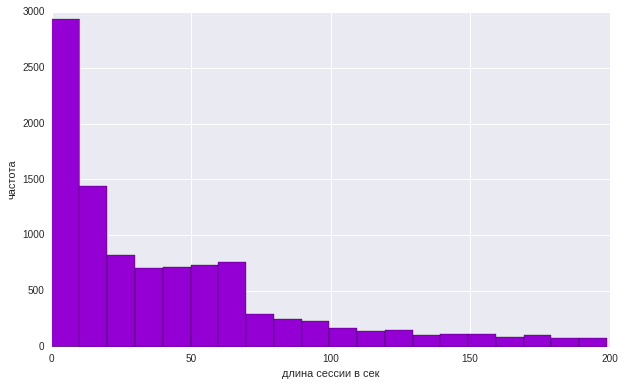

In [31]:
train_data_10users['session_timespan'][
    train_data_10users['session_timespan'] < 200].\
                    hist(
        bins = 20, 
        figsize = (10,6),
        color ='darkviolet')
plt.xlabel('длина сессии в сек')
plt.ylabel('частота')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

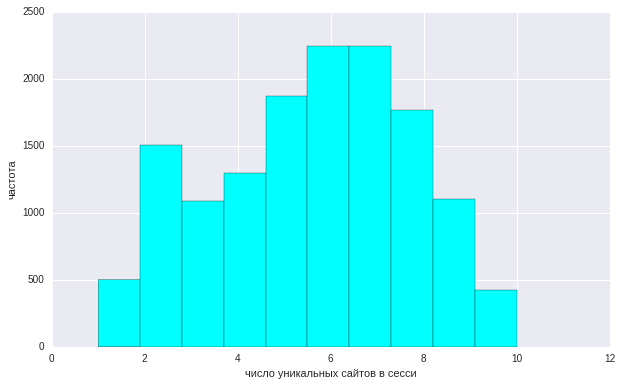

In [32]:
train_data_10users['#unique_sites'].hist(
    bins = 10, 
    figsize = (10,6),
    color ='aqua')
plt.xlabel('число уникальных сайтов в сесси')
plt.ylabel('частота') 

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

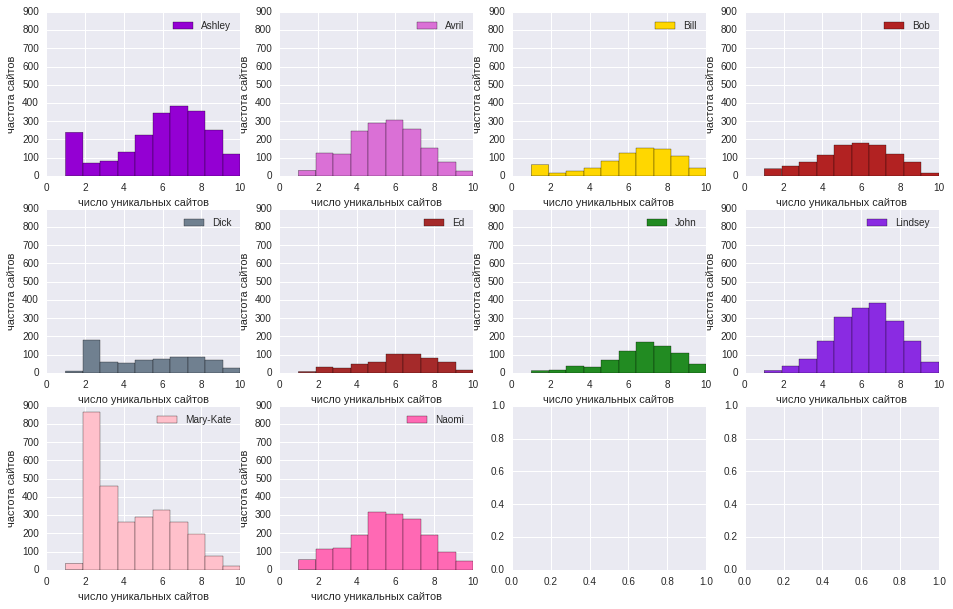

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.ravel()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(
    pd.groupby(train_data_10users, 'target')):
    
    axes[idx].hist(
        sub_df['#unique_sites'],
        bins = 10, 
        color = color_dic[user], 
        label = user)
    axes[idx].set_xlabel('число уникальных сайтов')
    axes[idx].axis([0, 10, 0, 900])
    axes[idx].set_ylabel('частота сайтов')
    axes[idx].legend()    

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

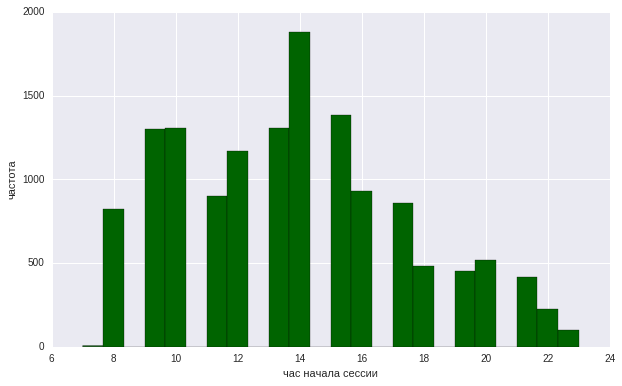

In [34]:
train_data_10users['start_hour'].hist(
    bins = 24, 
    figsize = (10,6),
    color ='darkgreen')
plt.xlabel('час начала сессии')
plt.ylabel('частота') 

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

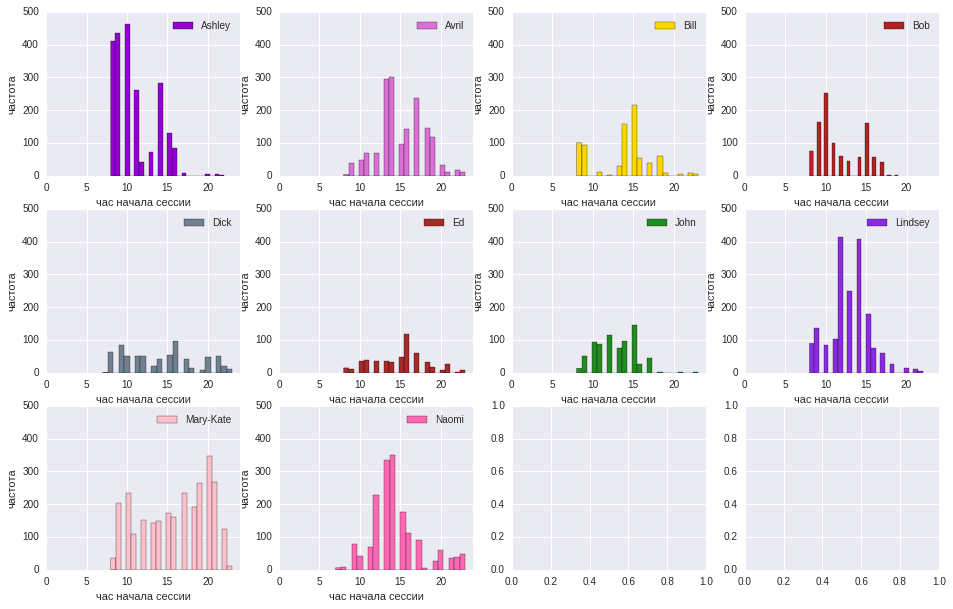

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.ravel()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(
    pd.groupby(train_data_10users, 'target')):
    
    axes[idx].hist(
        sub_df['start_hour'],
        bins = 24, 
        color = color_dic[user],
        label = user)
    axes[idx].set_xlabel('час начала сессии')
    axes[idx].axis([0, 24, 0, 500])
    axes[idx].set_ylabel('частота')
    axes[idx].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

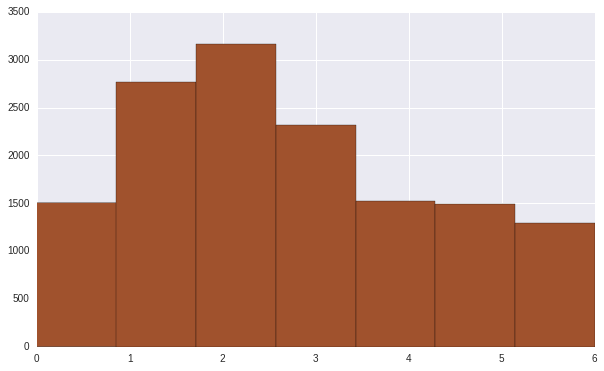

In [36]:
train_data_10users['day_of_week'].hist(
    bins = 7, 
    figsize = (10,6), 
    color = 'sienna')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

In [37]:
days_of_week = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

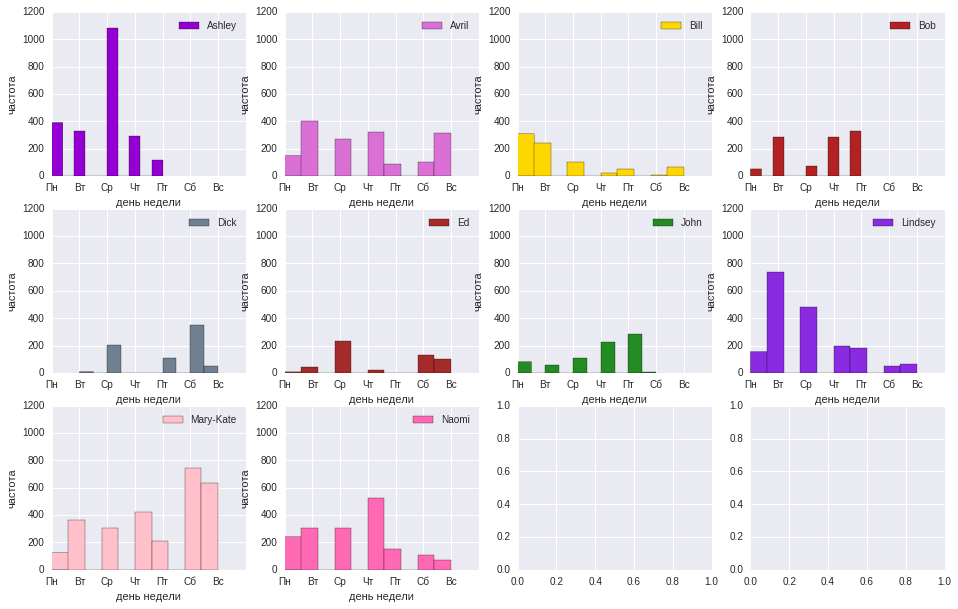

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
axes = axes.ravel()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(
    pd.groupby(train_data_10users, 'target')): 
      
    axes[idx].hist(
        sub_df['day_of_week'], 
        color = color_dic[user], 
        label = user)
    axes[idx].set_xlabel('день недели')
    axes[idx].axis([0, 7, 0, 1200])
    axes[idx].set_xticklabels(days_of_week)
    axes[idx].set_ylabel('частота')
    axes[idx].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

* по построенным гистограмамм видно что каждый из 10 пользователей имеет не похожие на других ("число уникальных сайтов", "час начала сессии", "день недели") можно сделать вывод что по этим признакам уже пользователи отличаются думаю признаки "site{N}" и "diff_time{N}" так же внесут разнообразие среди пользователей
- например 'Mary-Kate' чаще других 2 наиболее частых сайта в сессии,
- а у 'Dick' небольшая активность 
- 'Ashley' часще других посещает только 1 сайт, 
- 'Ashley' и 'Bob' чаще всего начинают сессию в рабочее время и в рабочие дни
- 'Ashley' чаще других начинает сессию в СР
- 'John' также чаще всего начинает сессию в рабочее время 
- 'Mary-Kate' начинает сессию чаще других в СБ и ВС
- 'Lindsey' активнее всех во ВТ и 7 уникальных сайтов чаще чем у других
- 'Dick' не активен в ПН и ЧТ
- 'Ed' не активен в ПТ
- 'Naomi', 'Avril' чаще других начинают сессию в 13,14 часов
- 'Avril' чаще начинает сессию в ВС чем в СБ
- 'Bill' чаще начинает сессию в 15,14 и ПН,ВТ
    

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [41]:
with open('capstone_websites_data/site_freq_10users.pkl', 'rb') as dic_pkl:
    dic_freq_10users = pickle.load(dic_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [42]:
freq_sorted = sorted(
    [(k,v[0],v[1]) for k,v in dic_freq_10users.items()], 
    key= lambda x: x[2], reverse =True )
top10_freqs = [x[2] for x in freq_sorted[:10]]
top10_sites = [x[0] for x in freq_sorted[:10]]

In [43]:
freq_sorted[:10]

[('s.youtube.com', 3102, 8300),
 ('www.google.fr', 4176, 7813),
 ('www.google.com', 4172, 5441),
 ('mail.google.com', 2426, 4158),
 ('www.facebook.com', 4104, 4141),
 ('apis.google.com', 272, 3758),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 2977, 3244),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 2967, 3094),
 ('plus.google.com', 2889, 2630),
 ('accounts.google.com', 140, 2089)]

In [44]:
[print(x) for x in zip( top10_sites, top10_freqs)]

('s.youtube.com', 8300)
('www.google.fr', 7813)
('www.google.com', 5441)
('mail.google.com', 4158)
('www.facebook.com', 4141)
('apis.google.com', 3758)
('r3---sn-gxo5uxg-jqbe.googlevideo.com', 3244)
('r1---sn-gxo5uxg-jqbe.googlevideo.com', 3094)
('plus.google.com', 2630)
('accounts.google.com', 2089)


[None, None, None, None, None, None, None, None, None, None]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

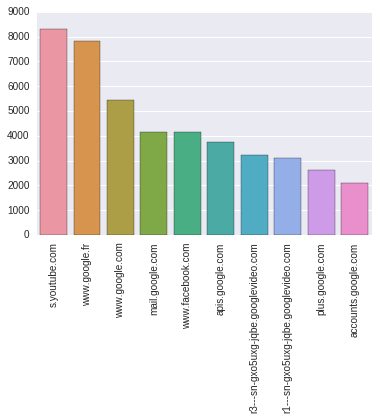

In [45]:
sns.barplot(x = top10_sites, y = top10_freqs)
plt.xticks(rotation=90)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(csv_files_mask, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
# selected features – among (session_timespan, ..., day_of_week) and your own new ones
with open('selected_features_10users.pkl', 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open('selected_features_150users.pkl', 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя проекта посвящена общему описанию проекта (.ipynb или pdf) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящая [статья](https://habrahabr.ru/post/308162/) по этому ремеслу)
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями, не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

Далее пройдите чисто техническое задание "Проверка построенных признаков", цель которого – удостовериться, что все мы одинаково создали признаки *session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour* и *day_of_week*.